In [3]:
import pandas as pd
import DataHandler
from ModelController import ModelController
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.SLIM.SLIMElasticNetRecommender import SLIMElasticNetRecommender
from xgboost import XGBRanker
from tqdm import tqdm
import scipy.sparse as sps
import numpy as np

from main2 import recommendations_list



In [4]:
URM_all_dataframe = pd.read_csv(filepath_or_buffer="Data/data_train.csv",
                                sep=",",
                                dtype={0:int, 1:int, 2:float},
                                engine='python')
users = pd.read_csv(filepath_or_buffer="Data/data_target_users_test.csv")

ICM = pd.read_csv(filepath_or_buffer="Data/data_ICM_metadata.csv",
                                sep=",",
                                dtype={0:int, 1:int, 2:float},
                                engine='python')

In [5]:
URM_all, ICM_all = DataHandler.create_urm_icm(URM_all_dataframe, ICM)

controller = ModelController()

EvaluatorHoldout: Ignoring 433 ( 1.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 161 ( 0.5%) Users that have less than 1 test interactions


In [6]:
from Recommenders.ScoresHybridRecommender import ScoresHybridRecommender
from EASE_R_Recommender import EASE_R_Recommender
from Recommenders.HybridOptunable2 import HybridOptunable2

slim1 = SLIMElasticNetRecommender(controller.URM_train)
slim1.load_model(folder_path="_saved_models", file_name="SLIMtrain")
stacked = sps.vstack([0.6814451172353111 * controller.URM_train, (1 - 0.6814451172353111) * controller.ICM_all.T]).tocsr()
slim2 = SLIMElasticNetRecommender(stacked)
slim2.load_model(folder_path="_saved_models", file_name="SLIMstackedTrainval1")
bestrp3 = RP3betaRecommender(controller.URM_train)
bestrp3.load_model(folder_path="_saved_models", file_name="rp3train")
hyb1 = HybridOptunable2(controller.URM_train)
hyb1.fit(0.27959722573911727,slim1,slim2)
ease1 = EASE_R_Recommender(controller.URM_train)
ease1.load_model(folder_path="_saved_models", file_name="easetrain")
hyb2 = HybridOptunable2(controller.URM_train)
hyb2.fit(0.18923840370620948,hyb1,bestrp3)
hyb3 = ScoresHybridRecommender(controller.URM_train, ease1, hyb2, bestrp3, slim1, slim1)
alpha=0.689217356
hyb3.fit(alpha,1-alpha,0,0,0)

SLIMElasticNetRecommender: Loading model from file '_saved_modelsSLIMtrain'
SLIMElasticNetRecommender: Loading complete
SLIMElasticNetRecommender: Loading model from file '_saved_modelsSLIMstackedTrainval1'
SLIMElasticNetRecommender: Loading complete
RP3betaRecommender: Loading model from file '_saved_modelsrp3train'
RP3betaRecommender: Loading complete
EASE_R_Recommender: Loading model from file '_saved_modelseasetrain'
EASE_R_Recommender: Loading complete


In [7]:
n_users, n_items = controller.URM_train.shape

training_dataframe = pd.DataFrame(index=range(0,n_users), columns = ["ItemID"])
training_dataframe.index.name='UserID'

training_dataframe

,ItemID
UserID,
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
35731,NaN
35732,NaN
35733,NaN


In [10]:
cutoff = 30

for user_id in tqdm(range(n_users)):
    recommendations = hyb3.recommend(user_id, cutoff = cutoff)
    training_dataframe.loc[user_id, "ItemID"] = recommendations

training_dataframe = training_dataframe.explode("ItemID")
training_dataframe

100%|██████████| 35736/35736 [02:05<00:00, 285.80it/s]


,ItemID
UserID,
0,14888
0,7703
0,14931
0,6348
0,572
...,...
35735,37192
35735,35753
35735,35712


In [11]:
URM_validation_coo = sps.coo_matrix(controller.URM_test)

correct_recommendations = pd.DataFrame({"UserID": URM_validation_coo.row,
                                        "ItemID": URM_validation_coo.col})
correct_recommendations

,UserID,ItemID
0,0,120
1,0,128
2,0,675
3,0,760
4,0,950
...,...,...
352916,35735,37191
352917,35735,37447
352918,35735,37503
352919,35735,37801


In [13]:
training_dataframe = pd.merge(training_dataframe, correct_recommendations, on=['UserID','ItemID'], how='left', indicator='Exist')
training_dataframe

,UserID,ItemID,Exist
0,0,14888,left_only
1,0,7703,left_only
2,0,14931,left_only
3,0,6348,left_only
4,0,572,left_only
...,...,...,...
1072075,35735,37192,left_only
1072076,35735,35753,left_only
1072077,35735,35712,left_only
1072078,35735,37304,left_only


In [14]:
training_dataframe["Label"] = training_dataframe["Exist"] == "both"
training_dataframe.drop(columns = ['Exist'], inplace=True)
training_dataframe

,UserID,ItemID,Label
0,0,14888,False
1,0,7703,False
2,0,14931,False
3,0,6348,False
4,0,572,False
...,...,...,...
1072075,35735,37192,False
1072076,35735,35753,False
1072077,35735,35712,False
1072078,35735,37304,False


In [15]:
from Recommenders.SLIM.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython
from Recommenders.NonPersonalizedRecommender import TopPop

top_pop = TopPop(controller.URM_train)
top_pop.fit()


item_cf = ItemKNNCFRecommender(controller.URM_train)
item_cf.load_model(folder_path="_saved_models", file_name="itemtrain")


item_cbf = ItemKNNCBFRecommender(controller.URM_train, controller.ICM_all)
item_cbf.fit()

rp3beta = RP3betaRecommender(controller.URM_train)
rp3beta.load_model(folder_path= "_saved_models",file_name="rp3train")

slimbpr = SLIM_BPR_Cython(controller.URM_train)
slimbpr.load_model(folder_path= "_saved_models",file_name="bprtrain")


other_algorithms = {
    "top_pop": top_pop,
    "item_cf": item_cf,
    "item_cbf": item_cbf,
    "rp3beta": rp3beta,
    "SLIM_BPR": slimbpr
}

ItemKNNCFRecommender: Loading model from file '_saved_modelsitemtrain'
ItemKNNCFRecommender: Loading complete
Cython module imported successfully.
Similarity column 38121 (100.0%), 573.29 column/sec. Elapsed time 1.11 min
RP3betaRecommender: Loading model from file '_saved_modelsrp3train'
RP3betaRecommender: Loading complete
SLIM_BPR_Recommender: Loading model from file '_saved_modelsbprtrain'
SLIM_BPR_Recommender: Loading complete


In [16]:
training_dataframe = training_dataframe.set_index('UserID')

for user_id in tqdm(range(n_users)):
    for rec_label, rec_instance in other_algorithms.items():

        item_list = training_dataframe.loc[user_id, "ItemID"].values.tolist()

        all_item_scores = rec_instance._compute_item_score([user_id], items_to_compute = item_list)

        training_dataframe.loc[user_id, rec_label] = all_item_scores[0, item_list]

training_dataframe = training_dataframe.reset_index()
training_dataframe = training_dataframe.rename(columns = {"index": "UserID"})
training_dataframe

100%|██████████| 35736/35736 [39:47<00:00, 14.97it/s]  


,UserID,ItemID,Label,top_pop,item_cf,item_cbf,rp3beta,SLIM_BPR
0,0,14888,False,84.0,0.596443,0.000000,0.329630,0.843104
1,0,7703,False,69.0,0.414451,0.208383,0.315615,0.877082
2,0,14931,False,84.0,0.483289,0.117672,0.217824,1.250883
3,0,6348,False,211.0,0.215074,0.000000,0.193364,0.512122
4,0,572,False,78.0,0.401442,0.000000,0.153998,0.639469
...,...,...,...,...,...,...,...,...
1072075,35735,37192,False,27.0,0.234921,0.000000,0.093568,0.642780
1072076,35735,35753,False,22.0,0.337339,0.156480,0.154681,0.650875
1072077,35735,35712,False,19.0,0.273041,0.114071,0.053850,0.214327
1072078,35735,37304,False,56.0,0.000000,0.000000,0.143927,0.633242


In [17]:

'''ICM_features = controller.ICM_all.to_dict()["feature_id"]
ICM_features'''




'ICM_features = controller.ICM_all.to_dict()["feature_id"]\nICM_features'

In [18]:
item_popularity = np.ediff1d(sps.csc_matrix(controller.URM_train).indptr)

training_dataframe['item_popularity'] = item_popularity[training_dataframe["ItemID"].values.astype(int)]

user_popularity = np.ediff1d(sps.csr_matrix(controller.URM_train).indptr)
training_dataframe['user_profile_len'] = user_popularity[training_dataframe["UserID"].values.astype(int)]


training_dataframe

,UserID,ItemID,Label,top_pop,item_cf,item_cbf,rp3beta,SLIM_BPR,item_popularity,user_profile_len
0,0,14888,False,84.0,0.596443,0.000000,0.329630,0.843104,84,90
1,0,7703,False,69.0,0.414451,0.208383,0.315615,0.877082,69,90
2,0,14931,False,84.0,0.483289,0.117672,0.217824,1.250883,84,90
3,0,6348,False,211.0,0.215074,0.000000,0.193364,0.512122,211,90
4,0,572,False,78.0,0.401442,0.000000,0.153998,0.639469,78,90
...,...,...,...,...,...,...,...,...,...,...
1072075,35735,37192,False,27.0,0.234921,0.000000,0.093568,0.642780,27,30
1072076,35735,35753,False,22.0,0.337339,0.156480,0.154681,0.650875,22,30
1072077,35735,35712,False,19.0,0.273041,0.114071,0.053850,0.214327,19,30
1072078,35735,37304,False,56.0,0.000000,0.000000,0.143927,0.633242,56,30


In [19]:
type(training_dataframe["ItemID"])

pandas.core.series.Series

In [20]:
training_dataframe = training_dataframe.sort_values("UserID").reset_index()
training_dataframe.drop(columns = ['index'], inplace=True)
training_dataframe

,UserID,ItemID,Label,top_pop,item_cf,item_cbf,rp3beta,SLIM_BPR,item_popularity,user_profile_len
0,0,14888,False,84.0,0.596443,0.000000,0.329630,0.843104,84,90
1,0,8604,False,46.0,0.125891,0.114287,0.144934,0.461293,46,90
2,0,2637,False,50.0,0.156046,0.000000,0.151087,0.417259,50,90
3,0,357,False,18.0,0.190027,0.229645,0.193463,0.202158,18,90
4,0,28958,False,28.0,0.183764,0.242260,0.140692,0.000000,28,90
...,...,...,...,...,...,...,...,...,...,...
1072075,35735,37801,True,37.0,0.885405,0.484419,0.320712,1.233479,37,30
1072076,35735,37657,False,76.0,1.283847,0.263317,0.451972,2.465509,76,30
1072077,35735,37304,False,56.0,0.000000,0.000000,0.143927,0.633242,56,30
1072078,35735,36322,False,19.0,0.489228,0.111659,0.204982,2.025169,19,30


In [21]:
groups = training_dataframe.groupby("UserID").size().values
groups

array([30, 30, 30, ..., 30, 30, 30], dtype=int64)

In [22]:
n_estimators = 50
learning_rate = 1e-1
reg_alpha = 1e-1
reg_lambda = 1e-1
max_depth = 5
max_leaves = 0
grow_policy = "depthwise"
objective = "pairwise"
booster = "gbtree"
use_user_profile = False
random_seed = None

XGB_model = XGBRanker(objective='rank:{}'.format(objective),
                      n_estimators = int(n_estimators),
                      random_state = random_seed,
                      learning_rate = learning_rate,
                      reg_alpha = reg_alpha,
                      reg_lambda = reg_lambda,
                      max_depth = int(max_depth),
                      max_leaves = int(max_leaves),
                      grow_policy = grow_policy,
                      verbosity = 0, # 2 if self.verbose else 0,
                      booster = booster,
                      )

In [23]:
'''candidate_recommender = SLIMElasticNetRecommender(controller.URM_train)
candidate_recommender.fit(alpha= 0.00022742003969239836, topK= 709, l1_ratio= 0.1488442906776265)
candidate_recommender.save_model(folder_path="_saved_models", file_name = "ModelName.SLIM_ElasticNetTrain")'''

'candidate_recommender = SLIMElasticNetRecommender(controller.URM_train)\ncandidate_recommender.fit(alpha= 0.00022742003969239836, topK= 709, l1_ratio= 0.1488442906776265)\ncandidate_recommender.save_model(folder_path="_saved_models", file_name = "ModelName.SLIM_ElasticNetTrain")'

In [24]:
# Check the data types of the columns in training_dataframe
print(training_dataframe.dtypes)

# Convert unsupported data types to supported ones
for column in training_dataframe.columns:
    if training_dataframe[column].dtype not in [int, float, bool, 'category']:
        training_dataframe[column] = training_dataframe[column].astype(float)

# Verify the data types after conversion
print(training_dataframe.dtypes)
y_train = training_dataframe["Label"]
X_train = training_dataframe.drop(columns=["Label"])

XGB_model.fit(X_train,
          y_train,
          group=groups,
          verbose=True)

UserID                int64
ItemID               object
Label                  bool
top_pop             float64
item_cf             float64
item_cbf            float64
rp3beta             float64
SLIM_BPR            float64
item_popularity       int32
user_profile_len      int32
dtype: object
UserID              float64
ItemID              float64
Label                  bool
top_pop             float64
item_cf             float64
item_cbf            float64
rp3beta             float64
SLIM_BPR            float64
item_popularity       int32
user_profile_len      int32
dtype: object


XGBRanker(base_score=None, booster='gbtree', callbacks=None,
          colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None,
          device=None, early_stopping_rounds=None, enable_categorical=False,
          eval_metric=None, feature_types=None, gamma=None,
          grow_policy='depthwise', importance_type=None,
          interaction_constraints=None, learning_rate=0.1, max_bin=None,
          max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None,
          max_depth=5, max_leaves=0, min_child_weight=None, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=50,
          n_jobs=None, num_parallel_tree=None, objective='rank:pairwise', ...)

In [25]:
# Let's say I want to compute the prediction for a group of user-item pairs, for simplicity I will use a slice of the data used
# for training because it already contains all the features
X_to_predict = X_train[X_train["UserID"] == 10]

XGB_model.predict(X_to_predict)

array([-0.44001505, -0.49371976, -0.33027402, -0.6113603 , -0.47958723,
       -0.17361446, -0.6700953 , -0.22988415, -0.68586457, -0.64111024,
       -0.459535  , -0.12689035, -0.40701514, -0.4707213 ,  0.03010033,
       -0.45935348, -0.34442133,  0.63495123,  0.5361128 ,  0.09246653,
        0.1864811 , -0.08701339, -0.1378643 , -0.0466735 , -0.37423828,
       -0.3102727 ,  0.03172045, -0.3504152 , -0.4107541 , -0.11564409],
      dtype=float32)

<AxesSubplot:title={'center':'Weight (Frequence)'}, xlabel='F score', ylabel='Features'>

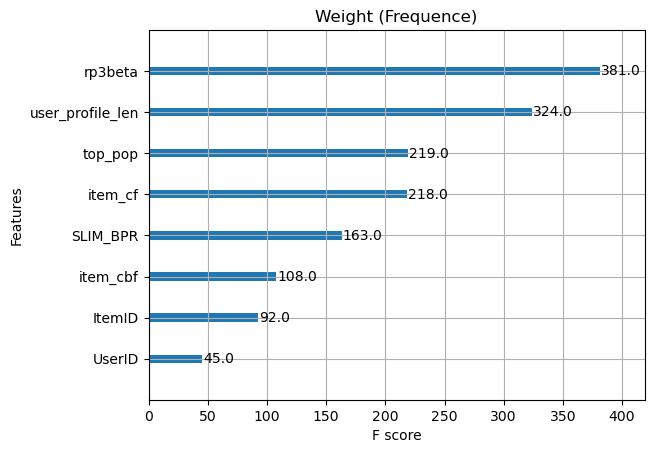

In [26]:
from xgboost import plot_importance

plot_importance(XGB_model, importance_type='weight', title='Weight (Frequence)')

In [27]:
X_train["UserID"] = X_train["UserID"].astype("category")
X_train["ItemID"] = X_train["ItemID"].astype("category")

In [28]:
XGB_model = XGBRanker(objective='rank:{}'.format(objective),
                      n_estimators = int(n_estimators),
                      random_state = random_seed,
                      learning_rate = learning_rate,
                      reg_alpha = reg_alpha,
                      reg_lambda = reg_lambda,
                      max_depth = int(max_depth),
                      max_leaves = int(max_leaves),
                      grow_policy = grow_policy,
                      verbosity = 0, # 2 if self.verbose else 0,
                      booster = booster,
                      enable_categorical = True,
                      tree_method = "hist",  # Supported tree methods are `gpu_hist`, `approx`, and `hist`.
                      )

XGB_model.fit(X_train,
          y_train,
          group=groups,
          verbose=True)

XGBRanker(base_score=None, booster='gbtree', callbacks=None,
          colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None,
          device=None, early_stopping_rounds=None, enable_categorical=True,
          eval_metric=None, feature_types=None, gamma=None,
          grow_policy='depthwise', importance_type=None,
          interaction_constraints=None, learning_rate=0.1, max_bin=None,
          max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None,
          max_depth=5, max_leaves=0, min_child_weight=None, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=50,
          n_jobs=None, num_parallel_tree=None, objective='rank:pairwise', ...)

In [29]:
X_to_predict = X_train[X_train["UserID"] == 10]

XGB_model.predict(X_to_predict)

array([-0.31502804, -0.44994628, -0.17233726, -0.31085843, -0.25083563,
       -0.23487677, -0.337567  , -0.3282081 , -0.3651626 , -0.32625598,
       -0.3284282 , -0.27010766, -0.2716764 , -0.2062679 , -0.0041054 ,
       -0.24335735, -0.18783635,  0.35033098,  0.23597474,  0.07238175,
       -0.07432956, -0.07973135, -0.06586855, -0.02610956, -0.20729114,
       -0.19125554,  0.02382144, -0.19481546, -0.28720537, -0.18551749],
      dtype=float32)

<AxesSubplot:title={'center':'Weight (Frequence)'}, xlabel='F score', ylabel='Features'>

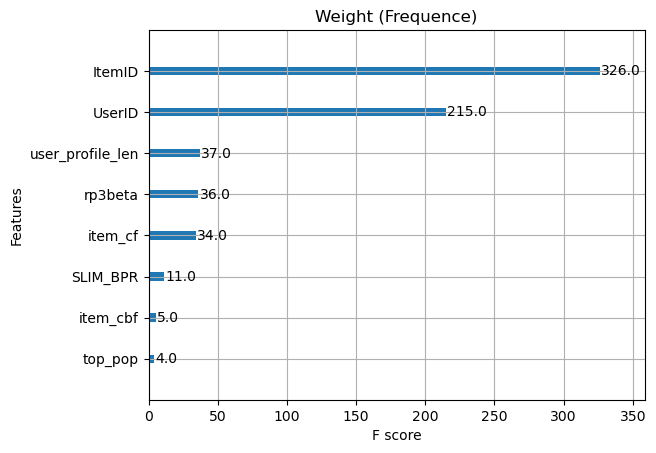

In [30]:
plot_importance(XGB_model, importance_type='weight', title='Weight (Frequence)')

In [31]:
slim1 = SLIMElasticNetRecommender(URM_all)
slim1.load_model(folder_path="_saved_models", file_name="SLIM_ElasticNetAll")
stacked = sps.vstack([0.6814451172353111 * URM_all, (1 - 0.6814451172353111) * controller.ICM_all.T]).tocsr()
slim2 = SLIMElasticNetRecommender(stacked)
slim2.load_model(folder_path="_saved_models", file_name="SLIMstackedAll1")
bestrp3 = RP3betaRecommender(URM_all)
bestrp3.fit(topK= 12 , alpha = 0.25843, beta= 0.357834)
hyb1 = HybridOptunable2(URM_all)
hyb1.fit(0.27959722573911727,slim1,slim2)
ease1 = EASE_R_Recommender(URM_all)
ease1.load_model(folder_path="_saved_models", file_name="easeall")
hyb2 = HybridOptunable2(URM_all)
hyb2.fit(0.18923840370620948,hyb1,bestrp3)
hyb3 = ScoresHybridRecommender(controller.URM_train, ease1, hyb2, bestrp3, slim1, slim1)
alpha=0.689217356
hyb3.fit(alpha,1-alpha,0,0,0)

SLIMElasticNetRecommender: Loading model from file '_saved_modelsSLIM_ElasticNetAll'
SLIMElasticNetRecommender: Loading complete
SLIMElasticNetRecommender: Loading model from file '_saved_modelsSLIMstackedAll1'
SLIMElasticNetRecommender: Loading complete
RP3betaRecommender: Similarity column 38121 (100.0%), 1968.70 column/sec. Elapsed time 19.36 sec
EASE_R_Recommender: Loading model from file '_saved_modelseaseall'
EASE_R_Recommender: Loading complete


In [32]:
user_recommendations_items = []
user_recommendations_user_id = []

for user_id in tqdm(range(n_users)):
    recommendations = hyb3.recommend(user_id, cutoff = cutoff)
    
    user_recommendations_items.extend(recommendations)
    user_recommendations_user_id.extend([user_id]*len(recommendations))

100%|██████████| 35736/35736 [03:25<00:00, 173.90it/s]


In [33]:
test_dataframe = pd.DataFrame({"UserID":user_recommendations_user_id, "ItemID":user_recommendations_items})
test_dataframe

,UserID,ItemID
0,0,2548
1,0,2697
2,0,7547
3,0,9911
4,0,14888
...,...,...
1072075,35735,36780
1072076,35735,37192
1072077,35735,35712
1072078,35735,36779


In [34]:
top_pop = TopPop(URM_all)
top_pop.fit()
item_cf = ItemKNNCFRecommender(URM_all)
item_cf.fit(similarity= 'tversky', topK= 5, shrink= 19, tversky_alpha= 0.20343700501082568, tversky_beta= 1.8980319969315242)
item_cbf = ItemKNNCBFRecommender(URM_all, ICM_all)
item_cbf.load_model(folder_path="_saved_models", file_name="ItemKNNCBFRecommender_all")
SLIM_BPR = SLIM_BPR_Cython(URM_all)
rp3beta=bestrp3

other_algorithms_all = {
    "top_pop": top_pop,
    "item_cf": item_cf,
    "item_cbf": item_cbf,
    "rp3beta": rp3beta,
    "SLIM_BPR": slimbpr
}

Cython module imported successfully.
Similarity column 38121 (100.0%), 1511.23 column/sec. Elapsed time 25.23 sec
ItemKNNCBFRecommender: Loading model from file '_saved_modelsItemKNNCBFRecommender_all'
ItemKNNCBFRecommender: Loading complete


In [35]:

test_dataframe = test_dataframe.set_index('UserID')

for user_id in tqdm(range(n_users)):
    for rec_label, rec_instance in other_algorithms_all.items():

        item_list = test_dataframe.loc[user_id, "ItemID"].values.tolist()

        all_item_scores = rec_instance._compute_item_score([user_id], items_to_compute = item_list)

        test_dataframe.loc[user_id, rec_label] = all_item_scores[0, item_list]

test_dataframe = test_dataframe.reset_index()
test_dataframe = test_dataframe.rename(columns = {"index": "UserID"})




100%|██████████| 35736/35736 [18:37<00:00, 31.96it/s]


In [36]:
item_popularity = np.ediff1d(sps.csc_matrix(URM_all).indptr)
test_dataframe['item_popularity'] = item_popularity[test_dataframe["ItemID"].values.astype(int)]

user_popularity = np.ediff1d(sps.csr_matrix(URM_all).indptr)
test_dataframe['user_profile_len'] = user_popularity[test_dataframe["UserID"].values.astype(int)]

test_dataframe

,UserID,ItemID,top_pop,item_cf,item_cbf,rp3beta,SLIM_BPR,item_popularity,user_profile_len
0,0,2548,149.0,0.082101,0.000000,0.168342,0.298365,149,114
1,0,2697,30.0,0.087470,0.000000,0.509957,0.235229,30,114
2,0,7547,43.0,0.375689,0.000000,0.511732,0.330391,43,114
3,0,9911,27.0,0.234467,0.000000,0.428227,0.503006,27,114
4,0,14888,110.0,0.256521,0.092722,0.296955,0.843104,110,114
...,...,...,...,...,...,...,...,...,...
1072075,35735,36780,67.0,0.190273,0.081673,0.082067,0.249823,67,37
1072076,35735,37192,29.0,0.306878,0.000000,0.284168,0.642780,29,37
1072077,35735,35712,23.0,0.369446,0.132709,0.077517,0.214327,23,37
1072078,35735,36779,32.0,0.171969,0.081673,0.082172,0.192374,32,37


In [37]:
test_dataframe = test_dataframe.sort_values("UserID").reset_index()
test_dataframe.drop(columns = ['index'], inplace=True)


test_dataframe

,UserID,ItemID,top_pop,item_cf,item_cbf,rp3beta,SLIM_BPR,item_popularity,user_profile_len
0,0,2548,149.0,0.082101,0.000000,0.168342,0.298365,149,114
1,0,8505,166.0,0.000000,0.000000,0.097763,0.346993,166,114
2,0,2637,67.0,0.107413,0.083077,0.200953,0.417259,67,114
3,0,2743,39.0,0.220747,0.056510,0.239450,0.322208,39,114
4,0,357,25.0,0.093566,0.084774,0.395788,0.202158,25,114
...,...,...,...,...,...,...,...,...,...
1072075,35735,37657,93.0,1.337090,0.094451,0.557155,2.465509,93,37
1072076,35735,36772,39.0,0.872134,0.165306,0.610348,1.555248,39,37
1072077,35735,36779,32.0,0.171969,0.081673,0.082172,0.192374,32,37
1072078,35735,36920,147.0,0.391505,0.000000,0.276931,1.616406,147,37


In [38]:
X = test_dataframe


In [39]:
predictions = XGB_model.predict(X)
predictions

array([-0.15568572, -0.25318366, -0.0497965 , ...,  0.98440474,
        1.5298235 ,  1.2809235 ], dtype=float32)

In [40]:
reranked_dataframe = test_dataframe.copy()
reranked_dataframe['rating_xgb'] = pd.Series(predictions, index=reranked_dataframe.index)
reranked_dataframe

,UserID,ItemID,top_pop,item_cf,item_cbf,rp3beta,SLIM_BPR,item_popularity,user_profile_len,rating_xgb
0,0,2548,149.0,0.082101,0.000000,0.168342,0.298365,149,114,-0.155686
1,0,8505,166.0,0.000000,0.000000,0.097763,0.346993,166,114,-0.253184
2,0,2637,67.0,0.107413,0.083077,0.200953,0.417259,67,114,-0.049796
3,0,2743,39.0,0.220747,0.056510,0.239450,0.322208,39,114,0.012898
4,0,357,25.0,0.093566,0.084774,0.395788,0.202158,25,114,-0.010681
...,...,...,...,...,...,...,...,...,...,...
1072075,35735,37657,93.0,1.337090,0.094451,0.557155,2.465509,93,37,1.639965
1072076,35735,36772,39.0,0.872134,0.165306,0.610348,1.555248,39,37,1.639965
1072077,35735,36779,32.0,0.171969,0.081673,0.082172,0.192374,32,37,0.984405
1072078,35735,36920,147.0,0.391505,0.000000,0.276931,1.616406,147,37,1.529824


In [41]:
reranked_dataframe = reranked_dataframe.sort_values(['UserID','rating_xgb'], ascending=[True, False])
reranked_dataframe

,UserID,ItemID,top_pop,item_cf,item_cbf,rp3beta,SLIM_BPR,item_popularity,user_profile_len,rating_xgb
22,0,7703,79.0,0.377827,0.261284,0.410197,0.877082,79,114,0.186323
19,0,7547,43.0,0.375689,0.000000,0.511732,0.330391,43,114,0.140569
28,0,399,228.0,0.283455,0.000000,0.258461,1.002502,228,114,0.088349
21,0,14888,110.0,0.256521,0.092722,0.296955,0.843104,110,114,0.081294
29,0,1425,39.0,0.170580,0.067446,0.321098,0.777575,39,114,0.057473
...,...,...,...,...,...,...,...,...,...,...
1072056,35735,34998,57.0,0.391233,0.113891,0.079775,0.000000,57,37,1.292605
1072079,35735,36968,27.0,0.175031,0.000000,0.165511,0.000000,27,37,1.280923
1072058,35735,35753,28.0,0.418558,0.000000,0.081554,0.650875,28,37,1.277164
1072059,35735,36780,67.0,0.190273,0.081673,0.082067,0.249823,67,37,1.179648


In [52]:
def write_reranked_recommendations(file_name):
    # Apertura del file in modalità scrittura
    f = open(file_name + ".csv", "w")
    
    # Scrittura dell'intestazione del file
    f.write("user_id,item_list\n")
    
    # Iterazione su tutti gli utenti
    for user_id in users["user_id"]:
        # Selezione delle prime 10 raccomandazioni per ogni utente
        recommendations_per_user = reranked_dataframe.loc[reranked_dataframe['UserID'] == user_id].ItemID.values[:10]
        
        # Creazione della riga formattata
        recommendation_string = f"{user_id}," + " ".join(map(str, recommendations_per_user))
        
        # Scrittura della riga nel file
        f.write(recommendation_string + "\n")
    
    # Chiusura del file
    f.close()


In [54]:
write_reranked_recommendations(file_name = "recomm")


In [55]:

submission = pd.read_csv("recomm.csv")
submission

,user_id,item_list
0,0,7703 7547 399 14888 1425 572 11966 2697 9911 2...
1,1,11146 7010 6348 4060 13766 13733 2820 2644 119...
2,2,22714 29963 21367 29964 22558 29640 16255 2262...
3,3,11753 6827 25140 25643 14103 3207 23023 25079 ...
4,4,4309 8505 18647 4572 15902 15731 3141 5819 352...
...,...,...
34226,35729,36527 35119 36844 36802 37525 37216 35548 3794...
34227,35730,38027 36770 36142 37873 37317 35443 37146 3757...
34228,35731,37170 36810 37873 36856 37109 36525 35394 3595...
34229,35734,37550 35093 37803 36561 35918 35914 34994 3534...
